## 1 Preprocessing

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nltk
nltk.download('gutenberg')
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')

import os
ROOTDIR = os.path.abspath(os.path.dirname('__file__'))
DATADIR = os.path.join(ROOTDIR, 'data')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import numpy as np 
import pandas as pd
import re
import gc
import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
import random
from tqdm  import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling
import tensorflow_hub as hub

Using TensorFlow backend.
W0808 16:23:58.605440 139769986602880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## 2 Cleaning Data

### 2.1 Stop Words

In [0]:
valid_forms = ['0','1']
blank = '----'

In [7]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
import re
import string

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FakeNewsTutorials/Group Task/data/fake_or_real_news.csv')
# data = shuffle(data, random_state=42)

text = data['text'].apply(cleanup)
sentences = constructLabeledSentences(text)
text.head()
y = data.label.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  # Remove the CWD from sys.path while we load stuff.


In [8]:
df = pd.DataFrame()
df["Title"] = data.title.values
df["Text"] = text
df["Label"] = y

vector = []
for i in range(len(data.title_vectors.values)):
    temp = data.title_vectors.values[i].strip('[ ').strip(' ]')
    temp = temp.replace('\n', ' ')
    temp = temp.replace('  ', ' ')
    temp = temp.replace('  ', ' ')
    temp = temp.replace('  ', ' ')
    temp = temp.replace('  ', ' ')
    temp = temp.split(" ")
    temp = [float(j) for j in temp]

    vector.append(temp)
vector = pd.DataFrame(vector)
print(vector.head(10))

X = df["Text"]
y = df["Label"]

        0         1         2    ...       297       298       299
0  0.011534  0.004214  0.019693  ... -0.021955 -0.018844 -0.000646
1  0.112677  0.025190 -0.002126  ... -0.037480 -0.003369 -0.014175
2  0.042530  0.043003  0.018484  ... -0.019186  0.011347  0.007236
3  0.108016  0.115832  0.028748  ... -0.090220  0.018878  0.032855
4  0.016902  0.007135 -0.007812  ... -0.011648  0.019537  0.045175
5  0.026981  0.022141  0.013287  ... -0.013693  0.034119  0.001712
6  0.050299  0.059615  0.027677  ... -0.089104  0.009580 -0.028881
7  0.030110  0.023762  0.010421  ... -0.015965  0.034937  0.024232
8  0.051177 -0.029867 -0.028427  ... -0.021460 -0.021718  0.014612
9  0.063163  0.131092  0.085660  ... -0.042489  0.069046  0.002264

[10 rows x 300 columns]


Delete data where text = ""

In [0]:
# print(vector.loc[106,:])
# print(df.loc[106,:])

df0 = df.copy()
for i in range(len(df)):
    if df.loc[i, 'Label'] == "REAL":
        df.loc[i, 'Label'] = 0
    elif df.loc[i, 'Label'] == "FAKE":
        df.loc[i, 'Label'] = 1
    if df.loc[i, 'Text'] == "":
        df = df.drop([i])
df["id"] = [i for i in range(len(df))]

In [10]:
df.head()

,Title,Text,Label,id
0,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...,1,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,1,1
2,Kerry to go to Paris in gesture of sympathy,us secretary state john f kerry said monday st...,0,2
3,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 lesson ...,1,3
4,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...,0,4


In [11]:
print('Label = 0(Real News): ', len(df[df['Label']==0]))
print('Label = 1(Fake News): ', len(df[df['Label']==1]))

Label = 0(Real News):  3171
Label = 1(Fake News):  3128


### 2.2 SMOTE (balance)

In [0]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df['Text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))


ValueError: ignored

## 3 EDA

### 3.1 Word Counts
Find the top 15 words by dataset/real or fake

In [0]:
def cleanwordcounts(text):
    #returns words counts minus stopwords from nltk and chinese characters
    #expects pandas series or single string
    #CountVectorizer expects iterable over raw text documents, so transform text
    #if simple string
    if type(text)==str:
        text = [text,'']
    
    stpwords = stopwords.words('english')
    #instantiate countvectorizer
    tokens = CountVectorizer(stop_words=stpwords,analyzer='word',token_pattern=r'\w+')
    #transform corpus into vector space
    textvec = pd.DataFrame(tokens.fit_transform(text).toarray())
    #create counts dataframe
    counts = pd.DataFrame(list(zip(tokens.get_feature_names(),textvec.sum().values)),columns=['word','counts'])
    #remove any chinese characters
    counts['word'] = counts['word'].str.replace(r'[^\x00-\x7F]+', '')
    #drop rows where chinese characters residedp
    counts.drop(counts[counts['word']==''].index, inplace=True)
    return counts.sort_values(by=['counts'],ascending=False).reset_index(drop=True)

In [13]:
# Fake News
fn = ''
# Real News
rn = ''
for i in range(len(df)):
    try:
        if df.loc[i, 'Label'] == 1:
            fn += df.loc[i, 'Text']
        elif df.loc[i, 'Label'] == 0:
            rn += df.loc[i, 'Text']
    except:
        pass 
df_list = [rn, fn]

words = []
for item in df_list:
    words.append(list(cleanwordcounts(item).word.head(15)))
df_words = pd.DataFrame(words).T
df_words.columns = ['Real News','Fake News']
df_words

,Real News,Fake News
0,said,us
1,trump,clinton
2,clinton,trump
3,would,people
4,one,one
5,people,would
6,president,hillary
7,state,said
8,new,new
9,us,like


### 3.2 Word Cloud

Word clouds are a great way to get a visual idea of the most common words from the texts.

In [0]:
from wordcloud import WordCloud
import random
#build list of stop words
stop_words = stopwords.words('english')
#function to pass to color_func to change default wordcloud colors
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
       

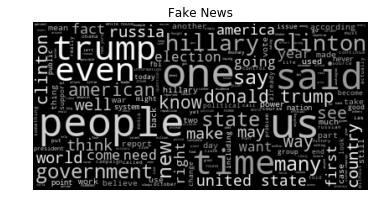

In [15]:
# Generate a word cloud image for fake news from data

wordcloud = WordCloud(max_font_size=50).generate(fn)
plt.figure()
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.title("Fake News")
# plt.savefig('./Images/realwordcloud.png',format='png')
plt.show()

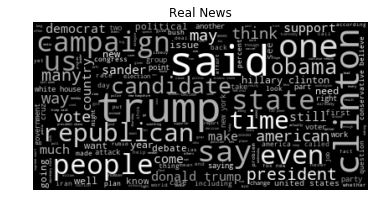

In [16]:
wordcloud = WordCloud(max_font_size=50).generate(rn)
plt.figure()
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.title("Real News")
# plt.savefig('./Images/realwordcloud.png',format='png')
plt.show()

## 4 Doc2Vec

In [17]:
from gensim.models import Doc2Vec

Text_INPUT_DIM = 50  # set the size of each vector is 50
text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
text_model.build_vocab(sentences)
text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
W0808 16:26:21.640617 139769986602880 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [18]:
X = np.zeros((data.shape[0], Text_INPUT_DIM))
i = 0
for i in range(data.shape[0]):
 X[i] = text_model.docvecs[i]

X[0]  # show the first text's vector

array([-0.30680299,  0.37830377, -0.07709567, -0.25266498,  0.54533237,
       -0.11973874,  0.1455411 ,  0.02506748, -0.33092529, -0.17649323,
       -0.01494977, -0.22573625,  0.37549639, -0.18170406,  0.16643153,
       -0.0955895 ,  0.23968063,  0.3901386 , -0.78215605,  0.04740021,
        0.02711709,  0.01009528,  0.82735658,  0.0710029 ,  0.07959105,
       -0.24704173,  0.24206103, -0.19023967,  0.20495613,  0.25275078,
        0.24753572,  0.08048184, -0.1745066 ,  0.05292838, -0.48596132,
        0.26230901, -0.38452333,  0.38246787,  0.4090783 , -0.13204466,
       -0.01143871,  0.43268296, -0.06359729, -0.3714613 , -0.49540627,
        0.16704749, -0.39041942,  0.19019771, -0.69734448, -0.23437637])

In [0]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)
y = pd.DataFrame(y)
# X.columns = ['x'+str(i) for i in range(1, Text_INPUT_DIM+1)]
y.columns = ['label']
for i in range(len(y)):
    if y.loc[i, 'label'] == "REAL":
        y.loc[i, 'label'] = 0
    elif y.loc[i, 'label'] == "FAKE":
        y.loc[i, 'label'] = 1
y = y.astype('int')
# split X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
1142,0.007355,0.016050,0.051843,0.026083,0.020947,-0.005493,-0.001414,-0.009619,0.012472,-0.016926,0.008973,0.009528,0.037014,0.015566,-0.018025,-0.003271,-0.015561,0.005860,-0.025562,-0.002695,0.005766,-0.022752,0.011667,0.027148,0.003627,0.005507,0.010316,0.017485,-0.006755,0.008691,0.030425,-0.010435,0.029413,-0.014070,-0.018355,0.001921,-0.007973,0.030509,-0.003525,0.014244,-0.040572,-0.007959,-0.008521,0.027537,-0.034618,0.002333,-0.005600,-0.019750,-0.039548,0.004474
2654,0.012351,0.117029,0.137272,0.012417,-0.003939,-0.098055,-0.015173,-0.022297,0.066756,-0.081354,0.060991,0.006490,0.018901,0.014463,0.065659,0.036360,0.013694,0.116003,-0.110839,-0.035175,-0.101079,-0.059991,0.094992,0.029239,0.101071,0.057080,0.061144,0.022224,-0.042431,0.123920,0.158707,0.045570,0.024152,-0.064355,-0.049665,0.021227,0.070853,0.179508,-0.015873,0.112075,-0.011988,0.033408,0.010564,0.018737,-0.092408,0.042627,-0.078329,-0.095024,-0.171029,0.068175
5395,-0.061079,0.234244,0.150630,-0.041425,0.146194,-0.085114,-0.063376,-0.055834,0.066020,-0.161498,0.019378,-0.058434,0.066962,-0.011707,0.107733,-0.054749,0.059966,0.197089,-0.315461,-0.054964,-0.076434,-0.030749,0.307953,0.091111,0.151531,0.012415,0.105040,0.023088,-0.079976,0.188504,0.236092,-0.009262,-0.034648,-0.046776,-0.081324,0.189231,0.023211,0.304173,0.064910,0.106738,-0.032334,0.112041,0.000950,-0.049162,-0.159988,0.091580,-0.211307,-0.068438,-0.341574,0.033908
1170,0.070349,0.490977,0.443173,0.023082,0.138977,-0.179258,-0.130035,-0.099713,0.383113,-0.397796,0.129415,-0.032619,0.009440,-0.029328,0.222048,0.009004,0.019495,0.424787,-0.444369,-0.139252,-0.402118,-0.205934,0.456959,0.334144,0.448481,0.163472,0.242000,0.087831,-0.192146,0.440365,0.597099,-0.038157,0.126564,-0.348568,-0.091564,0.258774,0.239446,0.707353,-0.063821,0.400218,-0.026649,0.091106,0.007644,0.074950,-0.325153,0.045596,-0.330999,-0.274088,-0.762517,0.247652
4371,0.190366,0.480938,0.203482,0.088892,0.207889,-0.343838,0.055128,0.089494,0.450930,-0.220046,0.157347,0.121590,0.013784,0.221621,0.114956,-0.191283,-0.131150,0.068402,-0.289293,-0.137006,0.012700,-0.153475,0.374152,0.252803,0.210548,0.358103,-0.114156,0.123219,-0.243441,0.215883,0.277871,0.191965,0.393423,-0.175920,0.137769,0.259604,-0.007152,0.727451,-0.250207,0.138473,-0.142808,0.287168,-0.005239,0.308147,-0.005854,0.120063,-0.294156,-0.121343,-0.083154,-0.045615


In [34]:
y_train.head()

,label
1142,0
2654,1
5395,1
1170,1
4371,1


## 5 XGBoost

### 5.1 Hypertuning

In [49]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

# use XGBClassifier
xgb_model = xgb.XGBClassifier()  


# use XGBClassifier
xgb_model = xgb.XGBClassifier()  

# this is the hyperparameter grid
# try each combination
# find the best hyper parameter conmination
hyper_param_grid = [
    {'max_depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]},
    {'subsample': [0.5, 0.8, 1], 'colsample_bytree': [0.5, 0.7, 1]},
]



# use grid search and cross validation to search the hyper parameter grid, set the fold is 5, judging the model with accuracy
xgb_model_grid = GridSearchCV(xgb_model, hyper_param_grid, cv=5, scoring='accuracy')

# fit the model with X_train and y_train
xgb_model_grid.fit(X_train, y_train.values.ravel())

# print the model with hyperparameters
print(xgb_model_grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


### 5.2 Predict

In [50]:
pred = xgb_model_grid.predict(X_test)  # Perform classification on an array of test vectors X.
print(pred)

[1 1 1 ... 1 1 0]


### 5.3 Evaluate

In [51]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix, precision, recall, f1
cm = metrics.confusion_matrix(y_test, pred)
print("confusion matrix: ")
print(cm)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
print("precision:   %0.3f" % precision)
print("recall:   %0.3f" % recall)
print("f1:   %0.3f" % f1)

confusion matrix: 
[[551  88]
 [ 79 549]]
precision:   0.862
recall:   0.874
f1:   0.868


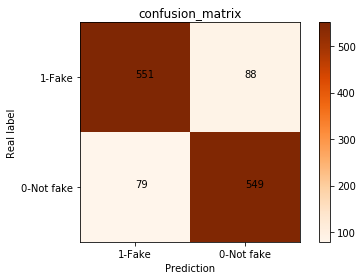

In [52]:
# plot the confusion matrix
classes = ['1-Fake', '0-Not fake']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)  # Display matrix by pixel
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (cm.size, 2))
for i, j in iters:
    plt.text(j, i, format(cm[i, j]))  # Display the corresponding number

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

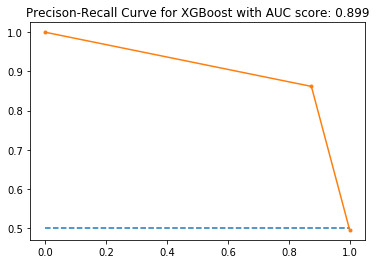

In [53]:
# plot the precision-recall curve for XGBoostwith AUC
from sklearn.metrics import auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# calculate precision-recall AUC
auc_xgb = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for XGBoost with AUC score: {:.3f}".format(auc_xgb))
# show the plot
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

X = vector
y = df['Label']
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [0]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

# use XGBClassifier
xgb_model = xgb.XGBClassifier()  

# this is the hyperparameter grid
# try each combination
# find the best hyper parameter conmination
hyper_param_grid = [
    {'max_depth': [1, 3, 10], 'learning_rate': [0.01, 0.05, 0.1, 1]},
    {'verbosity': [1, 2, 3], 'reg_alpha': [0, 0.5, 1], 'reg_lambda': [0, 0.5, 1]},
]

# use grid search and cross validation to search the hyper parameter grid, set the fold is 5, judging the model with accuracy
xgb_model_grid = GridSearchCV(xgb_model, hyper_param_grid, cv=5, scoring='accuracy')

# fit the model with X_train and y_train
xgb_model_grid.fit(X_train, y_train.values.ravel())

# print the model with hyperparameters
print(xgb_model_grid.best_estimator_)

In [0]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

# use XGBClassifier
xgb_model = xgb.XGBClassifier()  


# fit the model with X_train and y_train
xgb_model.fit(X_train, y_train.values.ravel())


In [0]:
pred = xgb_model.predict(X_test)  # Perform classification on an array of test vectors X.
print(pred)

In [0]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix, precision, recall, f1
cm = metrics.confusion_matrix(y_test, pred)
print("confusion matrix: ")
print(cm)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
print("precision:   %0.3f" % precision)
print("recall:   %0.3f" % recall)
print("f1:   %0.3f" % f1)

In [0]:
# plot the confusion matrix
classes = ['1-Fake', '0-Not fake']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)  # Display matrix by pixel
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (cm.size, 2))
for i, j in iters:
    plt.text(j, i, format(cm[i, j]))  # Display the corresponding number

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

In [0]:
# plot the precision-recall curve for XGBoostwith AUC
from sklearn.metrics import auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# calculate precision-recall AUC
auc_xgb = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for XGBoost with AUC score: {:.3f}".format(auc_xgb))
# show the plot
plt.show()